<h2>ZeitSci: A Quantitative Analysis of Trends in Modern Science</h2>

<h3>Technical Summary</h3> 
*(In Progress)*


**by Tariq Hassan**

***

Funding Simulation 
----
The animation-like graphic showing the movement of science grants around the world was made possible by the JavaScript library for Data Visualization, [Data Driven Documents (D3.js)](https://d3js.org). What follows are some brief technical notes on this process.

**Point Scaling**

$Let \hspace{2px} c$ and $m$ be scalars and $G$ be a set of research grants in some currency.

Now, $Let$

$$ p(x)= \frac {L}{1+\mathrm{e} ^{-k(x \cdot \phi^{-1} \hspace{2pt} -\hspace{2pt}x_{0})}} - \frac{L}{2} + m$$

$where$:
- $x_{0} = 0$
- $\phi = c \cdot {10}^{{\left \lfloor{\log_{10}{\max{G}}}\right \rfloor} \hspace{2pt}-\hspace{2pt}1}$
- $L = \hspace{2pt} \max{G}\cdot\phi^{-1}$




This is, essentially, the logistic equation with four properties of note:

1. $x_{0} = 0$ sets the x-value of the function's midpoint equal to zero.
2. $\phi$ keeps the value of $p(x)$ close to zero, even for large values of $\max D$.
3. $m$ sets a floor for the lowest value that can be returned (notice that all other terms vanish if $x = 0$).
4. $\frac{L}{2}$ sets the y-value of the function's midpoint equal to zero. 

Additionally:<br>
- $k$ controls the *steepness* of the function.
- $c$ adds additional control over the distance of the values from zero. Specifically, larger values of $c$ reduce the distance of values returned by $p(x)$ from zero.

Let's quickly look at this as code.

In [1]:
# Imports
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

While this procedure is written in JavaScript for use by D3.js during the simulation, an implementation in python is shown below for simplicity.<br> 
Note: `c` and `k` have be set to the values they are in the simulation. 

In [2]:
def logistic_algo(x, max_value, min_value=1.5, c=0.85, k=0.1):
    """
    Algorithm for scaling a given point's radius according to a Logistic Function.
    """
    phi = c * (10**(int(math.log10(max_value)) - 1))

    L = max_value/phi
    denominator = 1 + math.e**(-1 * k * (x/phi))

    return L/denominator - L/2 + min_value

If we graph this function, it should look familiar. 

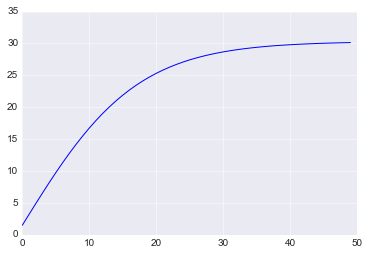

In [3]:
x = list(range(50))
y = [logistic_algo(p, max(x)) for p in x]

# compose the plot
plt.plot(x, y) 

**Homogenizing Longitude and Latitude**

For many of the organizations in the database, there were multiple coordinates found.
This is partly a side effect of postal codes being used to work out geographic location.
For instance, while two different departments may belong to the same university, their postal codes may vary slightly.

To homogenize these discrepancies, I wrote an algorithm to find the most plausible central point of
all of the points mapped to a given organization. While the algorithm itself is relatively straightforward,
it is surprisingly effective at solving this problem. 

Steps:
1. Calculate the distance from each unique point to every other unique point using haversine formula.
2. Divide by the number of times that unique point appears in the input list. This reduces the chance of annomilies in the mapping being selected by biasing selection towards coordinates which appear fequently.
3. Select the coordinate which has the smallest weighted value.
4. Check the weighted value against some scalar threshold (optional).
5. Return this coordinate if it is less than or equal to the thresshold; else return NaN.

In code, this procedure can be expressed as follows:

In [4]:
# Imports
import numpy as np
from collections import Counter
from haversine import haversine

In [5]:
def most_central_point(geos_array, valid_medoid):
    """
    Algorithm to find the point that is most central (i.e., medoid)
    using the haversine formula. Distances are weighted by the number of observations.

    :param geos_array: a list of coordinate
    :type geos_array: list of tuples (must be immutable as this will be hashed)
    :param valid_medoid: min for mean distance to all other points / number of observations.
    :type valid_medoid: float or int
    :return: medoid coordinate
    """
    # Count the number times each coordinate appears in `geos_array`
    geos_array_count = dict(Counter(geos_array))
    
    # Define a list of unique coordinates
    uniuqe_geos = list(set(geos_array))

    # Compute the distance from each point to all of the others
    coord_dict = dict()
    for i in uniuqe_geos:
        coord_dict[i] = [haversine(i, j) for j in uniuqe_geos if j != i]

    # Compute the mean distance for each coordinate and divide by the number of times it occured
    coord_dict_mean = {k: mean(v)/float(geos_array_count[k]) for k, v in coord_dict.items()}

    # Use the coordinate with the smallest corresponding value
    medoid_mean_coord = min(coord_dict_mean, key=coord_dict_mean.get)

    # Check against threshold
    if coord_dict_mean[medoid_mean_coord] <= valid_medoid:
        return medoid_mean_coord
    else:
        return np.NaN

While I have yet to formalize a validation procedure, by simple inspection this process appears to reliably see through the noise and select a single, plausable coordinate to represent most of the organizations in the database.